In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLSSVM import VQLSSVM

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

np.set_printoptions(precision=4, suppress=True)

In [2]:
shots: int = 10000
gamma: float = 0.01 # regularization parameter
subsetSize: int = 7
classToFilterOut: int = 2

In [3]:
def prepareDataset(normalizeValues: bool = False, dataset: str = "iris") -> (np.ndarray, np.ndarray, np.array, np.array):
    if dataset == "iris":
        X,y = datasets.load_iris(return_X_y=True)
        X = X[y!=classToFilterOut]
        y = y[y!=classToFilterOut]
    elif dataset == "breastCancer":
        X,y = datasets.load_breast_cancer(return_X_y=True)
    elif dataset == "dummyData":
        X, y = datasets.make_classification(
            n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
        )
    elif dataset == "digits":
        X, y = datasets.load_digits(n_class=2, return_X_y=True)
    elif dataset == "wine":
        X, y = datasets.load_wine(return_X_y=True) # 3 classes; filter out some class
    else: 
        raise ValueError("Dataset not yet implemented")
    y: np.array = np.where(y == 0, -1, 1) # might cause some problems in a future

    if normalizeValues: # normalize values returns nan with digits dataset
        max = np.max(X, axis=0)
        min = np.min(X, axis=0)
        X = (2*X - min - max) / (max - min)
    return train_test_split(X, y, test_size=(X.shape[0]-subsetSize)/(X.shape[0]), random_state=43)

In [4]:
xTrain, xTest, yTrain, yTest = prepareDataset(normalizeValues=True, dataset="iris")
print(xTrain)

[[ 0.5556  0.      0.7073  0.6471]
 [-0.1852  0.5833 -0.8537 -0.6471]
 [ 0.7037 -0.25    0.7561  0.4118]
 [-0.4074  0.4167 -0.7561 -0.6471]
 [-0.4815  0.0833 -0.8049 -0.8824]
 [-0.037  -0.25    0.2683  0.4118]
 [ 0.4074 -0.8333  0.7073  0.6471]]


# VQLS-LSSVM state vectors

In [10]:
import LSSVM
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)

input = LSSVM.lssvmMatrix(xTrain, gamma, "linearKernel")
response, coefs0 = vqlssvmVectors.getLCU(input,method="TPD")
response1, coefs1 = vqlssvmVectors.getLCU(input,method="sparsePauliOp")
print (response)
print (response1)
print(response == response1)
print (coefs0)

print (coefs1)
print(coefs0 == coefs1)

['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ', 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ', 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI', 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
True
[88.64105774546628, 0.4679490309569777, -12.851719551176487, 0.05699311524820916, -0.5435818165610514, 0.1638224183632393, (-0.31023739016069574-0j), -12.585375411560717, 0.7372419340072064, -12.538982507958044, 0.06352380828398643, -0.33875751836391377, 0.1192557177090299, 0.5491034694857597, 0.4006117988485829, 0.6422143456480314, (0.5151019368725922+0j), -0.2673877851401383, 0.24884587660004653, 1.084608259147122, (-0.04673286536906107-0j), (-0.7972880120161648-0j), (-0.52355653

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

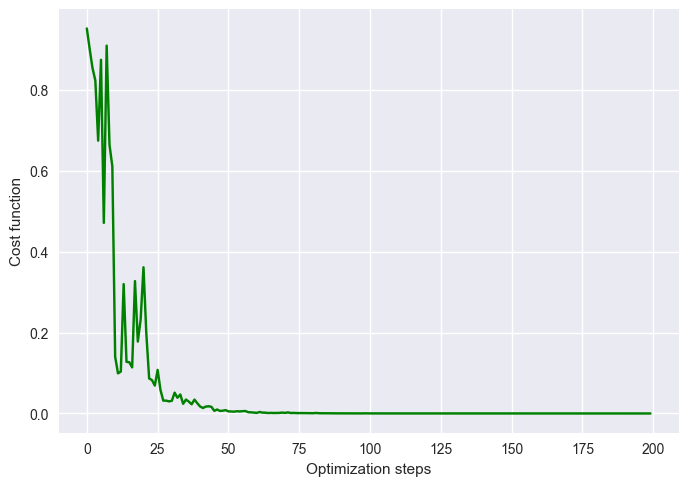

In [5]:
vqlssvmVectors: VQLSSVM = VQLSSVM(gamma, shots)


vqlssvmVectors.train(xTrain, yTrain, quantumSimulation=False, verbose=True, iterations = 200, method="COBYLA")
vqlssvmVectors.plotCost()

In [6]:
costCOBYLA = vqlssvmVectors.getCostHistory()
print("Cost history:")
print(costCOBYLA)

Cost history:
[0.951783227797704, 0.9011823543095978, 0.8540339926673253, 0.8232678579928371, 0.6744008807163258, 0.8744174055483842, 0.47113156545803714, 0.9093373679336417, 0.6643061312791347, 0.611043183451305, 0.14002614314238448, 0.09913472928248312, 0.1036051195890676, 0.31989180835477005, 0.12763602487506753, 0.12666677364755707, 0.11386698234253023, 0.3272490375967948, 0.17773437108365364, 0.23258405672767013, 0.3614503184827469, 0.19823309105732623, 0.08657939923512348, 0.08255825855410148, 0.0689011754281389, 0.10772711026560267, 0.05795474263617495, 0.03170641303545474, 0.03174857086059002, 0.029901894596234824, 0.031221826480740345, 0.05144432562304013, 0.03885143983768047, 0.04695071732727374, 0.02385288790305584, 0.034453835470447336, 0.029320061285308174, 0.022759150590204724, 0.03426785390288156, 0.025346291784003494, 0.017156157626089685, 0.013580338905008649, 0.016972923985923427, 0.017915767586938913, 0.01635690833758885, 0.006509265182436108, 0.00977102601381108, 0.

In [7]:
print(vqlssvmVectors.predict(xTest))

[-0.073 +0.j -0.1285+0.j -0.008 +0.j -0.1232+0.j -0.0617+0.j  0.082 +0.j
 -0.0006+0.j  0.0459+0.j -0.1047+0.j -0.0077+0.j -0.1218+0.j -0.1525+0.j
  0.1019+0.j -0.0918+0.j  0.0062+0.j -0.1677+0.j -0.0403+0.j -0.1256+0.j
  0.042 +0.j  0.0867+0.j -0.0532+0.j -0.1345+0.j  0.0734+0.j  0.0269+0.j
 -0.1007+0.j  0.0211+0.j  0.0683+0.j  0.1176+0.j  0.0802+0.j -0.071 +0.j
 -0.1542+0.j -0.0388+0.j -0.1261+0.j -0.0699+0.j -0.0405+0.j -0.0618+0.j
  0.0669+0.j -0.0935+0.j -0.0953+0.j -0.1162+0.j  0.0028+0.j -0.0795+0.j
 -0.0351+0.j -0.1427+0.j -0.0133+0.j  0.1227+0.j -0.0708+0.j  0.0207+0.j
 -0.0839+0.j -0.0647+0.j -0.0955+0.j  0.1052+0.j  0.0414+0.j  0.0384+0.j
 -0.0867+0.j  0.0955+0.j  0.0493+0.j -0.1191+0.j -0.1146+0.j -0.0735+0.j
 -0.1775+0.j  0.0808+0.j -0.1318+0.j -0.0206+0.j -0.0035+0.j  0.1356+0.j
  0.0642+0.j -0.0983+0.j -0.0919+0.j  0.0334+0.j  0.1384+0.j -0.0695+0.j
  0.0228+0.j -0.0701+0.j  0.0778+0.j -0.059 +0.j -0.1301+0.j  0.1118+0.j
 -0.0759+0.j -0.0917+0.j  0.0194+0.j  0.0498+0.j -0

In [8]:
print("Accuracy:",vqlssvmVectors.accuracy(xTest, yTest))

Accuracy: 0.9032258064516129


# VQLS-LSSVM quantum

Condition number of the matrix:  1549.1963269879666
LS-SVM Matrix:
 [[  0.       1.       1.       1.       1.       1.       1.       1.    ]
 [  1.     101.2276  -1.1254   1.1922  -1.1798  -1.4077   0.4356   1.1453]
 [  1.      -1.1254 101.522   -1.188    1.3826   1.3958  -0.6344  -1.584 ]
 [  1.       1.1922  -1.188  101.2989  -1.229   -1.3315   0.4088   1.2963]
 [  1.      -1.1798   1.3826  -1.229  101.33     1.4104  -0.5584  -1.4667]
 [  1.      -1.4077   1.3958  -1.3315   1.4104 101.6651  -0.5823  -1.4058]
 [  1.       0.4356  -0.6344   0.4088  -0.5584  -0.5823 100.3054   0.6494]
 [  1.       1.1453  -1.584    1.2963  -1.4667  -1.4058   0.6494 101.7794]]
['III', 'IIX', 'IIZ', 'IXI', 'IXX', 'IXZ', 'IYY', 'IZI', 'IZX', 'IZZ',
 'XII', 'XIX', 'XIZ', 'XXI', 'XXX', 'XXZ', 'XYY', 'XZI', 'XZX', 'XZZ',
 'YIY', 'YXY', 'YYI', 'YYX', 'YYZ', 'YZY', 'ZII', 'ZIX', 'ZIZ', 'ZXI',
 'ZXX', 'ZXZ', 'ZYY', 'ZZI', 'ZZX', 'ZZZ']
Pauli matrix coeffitients [(88.64105774546628+0j), (0.4679490309569777+0j),

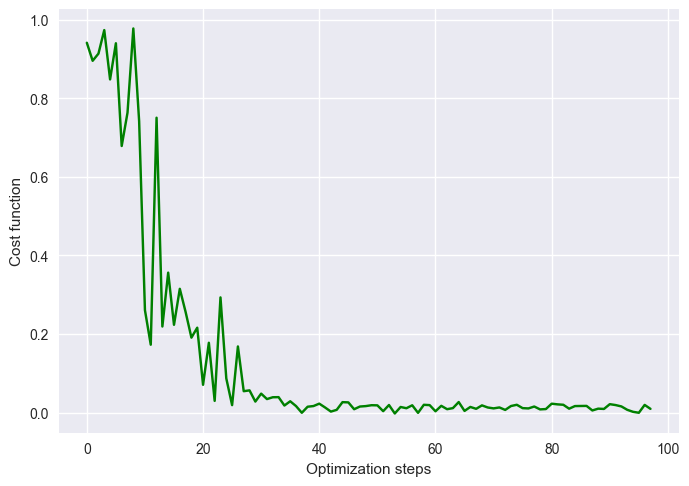

In [9]:
vqlssvmQuantum: VQLSSVM = VQLSSVM(gamma, shots)
vqlssvmQuantum.train(xTrain, yTrain, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvmQuantum.plotCost()

In [10]:
costCOBYLA = vqlssvmQuantum.getCostHistory()
print("Cost history:")
print(costCOBYLA)

import csv

with open('costCOBYLA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Iteration', 'CostFunction'])
    for i in range(len(costCOBYLA)):
        writer.writerow([i, costCOBYLA[i]])


Cost history:
[0.941447225978723, 0.8955092919289617, 0.9137602377895296, 0.9736353837387259, 0.8481060954849272, 0.940134341264565, 0.6786514993802094, 0.763466973793655, 0.977768466736527, 0.742011369493175, 0.26089981917753713, 0.1729281555081581, 0.7506154081413958, 0.21923243933338732, 0.3563398941234851, 0.22359016954713695, 0.3151311581118825, 0.256148239648471, 0.190881814389961, 0.21623221708524853, 0.07087868128415109, 0.17786219979942297, 0.02996808128801176, 0.2933048856073972, 0.08718850251000354, 0.019139691850282747, 0.16849863212841443, 0.054611148736975146, 0.05669377560026756, 0.02819912459218188, 0.048404868863490935, 0.03455167928838887, 0.03918880780539069, 0.039447444413321486, 0.01810153243601209, 0.028959931202451772, 0.016755938586138996, -0.00036577941811488657, 0.015098190963441782, 0.016773462003330075, 0.022904086669520818, 0.013165635624882377, 0.002725673984640964, 0.0071215131389781305, 0.02669791923730158, 0.026145387998399494, 0.008719108225654693, 0.0

In [11]:
print("Predictions:\n", vqlssvmQuantum.predict(xTest))
print("Accuracy: ", vqlssvmQuantum.accuracy(xTest, yTest))

Predictions:
 [-0.0539+0.j -0.107 +0.j -0.001 +0.j -0.1059+0.j -0.0375+0.j  0.0965+0.j
  0.0216+0.j  0.0634+0.j -0.0853+0.j  0.0141+0.j -0.0986+0.j -0.1287+0.j
  0.1109+0.j -0.0736+0.j  0.027 +0.j -0.1432+0.j -0.0279+0.j -0.102 +0.j
  0.0581+0.j  0.103 +0.j -0.0396+0.j -0.1103+0.j  0.0884+0.j  0.0455+0.j
 -0.0827+0.j  0.0414+0.j  0.0845+0.j  0.1275+0.j  0.0958+0.j -0.056 +0.j
 -0.1294+0.j -0.0282+0.j -0.1033+0.j -0.0556+0.j -0.0279+0.j -0.0366+0.j
  0.085 +0.j -0.0743+0.j -0.076 +0.j -0.0975+0.j  0.0286+0.j -0.0613+0.j
 -0.0211+0.j -0.1211+0.j  0.0099+0.j  0.1352+0.j -0.0531+0.j  0.0413+0.j
 -0.0658+0.j -0.0487+0.j -0.0779+0.j  0.1149+0.j  0.0578+0.j  0.0538+0.j
 -0.0689+0.j  0.1113+0.j  0.0667+0.j -0.0976+0.j -0.0911+0.j -0.0581+0.j
 -0.1471+0.j  0.0998+0.j -0.1093+0.j  0.0033+0.j  0.0194+0.j  0.1478+0.j
  0.0781+0.j -0.079 +0.j -0.0727+0.j  0.0509+0.j  0.1509+0.j -0.0535+0.j
  0.0421+0.j -0.0417+0.j  0.094 +0.j -0.0465+0.j -0.1086+0.j  0.1281+0.j
 -0.0579+0.j -0.0745+0.j  0.0397+0.j 

# LSSVM (work in progresss)

In [12]:
# lssvmMatrix1: np.ndarray = lssvmMatrix(xTrain, gamma, "linearKernel")
# yVector: np.array = prepareLabels(yTrain)
# print(yVector)
# print ("Condition number of the matrix: ", np.linalg.cond(lssvmMatrix1))
# print("LS-SVM Matrix:\n", lssvmMatrix1)
# print(yVector)

# solution: np.array = np.linalg.solve(lssvmMatrix1, yVector)
# print("Solution:", solution)
# print ("Norm of the solution: ",solution/np.linalg.norm(solution))

# bias: float = solution[0]
# weights: np.array = solution[1:]

# vqlssvmLSSVM: VQLSSVM = VQLSSVM(gamma,10)
# vqlssvmLSSVM.xTrain = xTrain
# vqlssvmLSSVM.xTrainSize = xTrain.shape[0]
# vqlssvmLSSVM.weights = weights
# vqlssvmLSSVM.b = bias
# predictions: np.array = vqlssvmLSSVM.predict(xTest)
# classVals = [vqlssvmLSSVM.assignClass(i) for i in predictions]
# print("Predictions:", predictions)
# print("Class values:", classVals)
# print("yTest:", yTest)
# # print(yTest)
# print("Accuracy:", vqlssvmLSSVM.accuracy(xTest, yTest))

# Classical SVM

In [15]:
clf = SVC(kernel='linear')
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print("Accuracy:", accuracy_score(yTest, yPred))

Accuracy: 1.0
